In [37]:
import pandas as pd
import numpy as np  
import aqi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime
import itertools
from typing import Tuple, Any, Optional
import json
import pickle
import warnings

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, seasonal_mean

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# from tensorflow.keras.models import Sequential, load_model, Model
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.saving import register_keras_serializable

warnings.filterwarnings('ignore')


In [38]:
data_path = r'D:\AQI_forecasting\backend\data\dht_sensor.csv'
df = pd.read_csv(data_path)

In [39]:
df

,Timestamp,Temperature (°C),Humidity (%)
0,2025-02-17 12:44:43,29.8,64
1,2025-02-17 12:45:43,29.9,64
2,2025-02-17 12:46:43,29.9,64
3,2025-02-17 12:47:44,29.9,64
4,2025-02-17 12:48:44,29.9,64
...,...,...,...
105,2025-02-17 14:41:14,25.1,42
106,2025-02-17 14:42:14,25.2,42
107,2025-02-17 14:43:14,25.1,42
108,2025-02-17 14:44:14,25.1,43


In [41]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [48]:
df

,Temperature (°C),Humidity (%)
Timestamp,,
2025-02-17 12:44:43,29.8,64
2025-02-17 12:45:43,29.9,64
2025-02-17 12:46:43,29.9,64
2025-02-17 12:47:44,29.9,64
2025-02-17 12:48:44,29.9,64
...,...,...
2025-02-17 14:41:14,25.1,42
2025-02-17 14:42:14,25.2,42
2025-02-17 14:43:14,25.1,42


In [43]:
y = df['Temperature (°C)']

# Fit the auto ARIMA model
model = pm.auto_arima(y, start_p=1, start_q=1,
                       seasonal=False,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-194.696, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-135.956, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-184.216, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-161.243, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-126.123, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-193.869, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-194.108, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-173.881, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-194.798, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-193.903, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-191.951, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-195.674, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-183.764, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-194.996, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [53]:
forecast_periods = 30
forecast_values, conf_int = model.predict(n_periods=forecast_periods,return_conf_int=True)

print(forecast_values)
print(conf_int)

110    25.092679
111    25.086127
112    25.080265
113    25.075019
114    25.070324
115    25.066123
116    25.062364
117    25.059000
118    25.055990
119    25.053296
120    25.050886
121    25.048729
122    25.046799
123    25.045072
124    25.043526
125    25.042143
126    25.040905
127    25.039798
128    25.038806
129    25.037920
130    25.037126
131    25.036416
132    25.035780
133    25.035212
134    25.034703
135    25.034247
136    25.033840
137    25.033475
138    25.033149
139    25.032857
dtype: float64
[[24.9055272  25.27983037]
 [24.76027507 25.41197969]
 [24.61079097 25.5497387 ]
 [24.45713775 25.6928997 ]
 [24.30076308 25.83988538]
 [24.1430287  25.989218  ]
 [23.98503682 26.13969153]
 [23.82764444 26.29035611]
 [23.67150633 26.44047382]
 [23.51711627 26.58947652]
 [23.36484107 26.73693082]
 [23.21494767 26.88251023]
 [23.06762433 27.02597318]
 [22.92299739 27.16714565]
 [22.7811444  27.30590739]
 [22.6421046  27.44218098]
 [22.50588718 27.57592305]
 [22.37247791 27

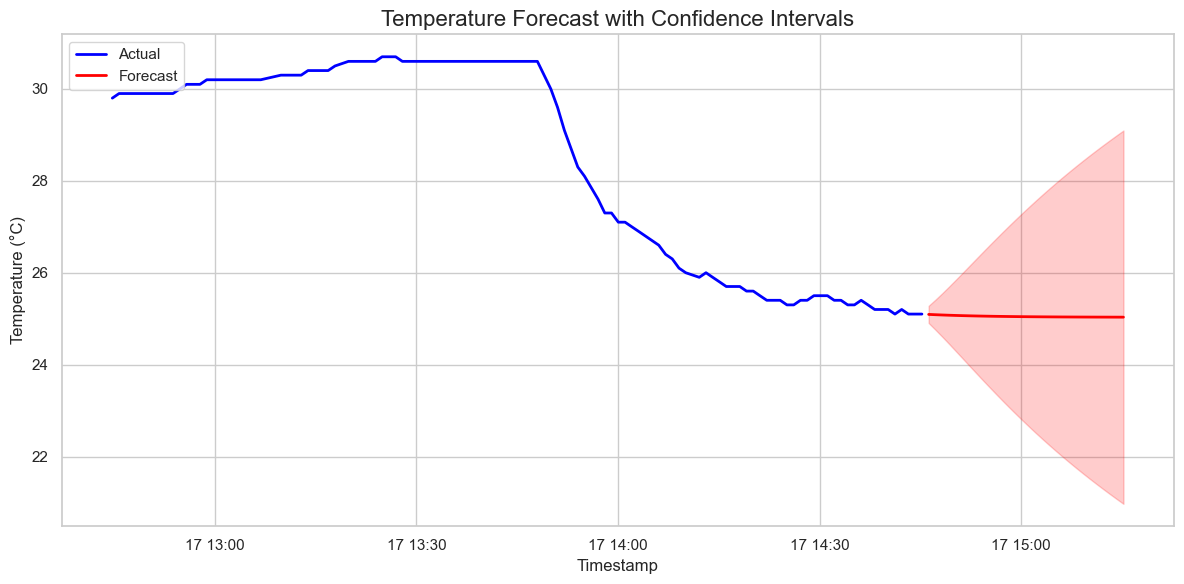

In [54]:
sns.set(style="whitegrid")

forecast_index = pd.date_range(y.index[-1], periods=forecast_periods + 1, freq='T')[1:]

plt.figure(figsize=(12, 6))

sns.lineplot(x=y.index, y=y, label="Actual", color='blue', lw=2)


sns.lineplot(x=forecast_index, y=forecast_values, label="Forecast", color='red', lw=2)

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2)


plt.title("Temperature Forecast with Confidence Intervals", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [59]:
from pmdarima import auto_arima
import pandas as pd

# Example: Use temperature and humidity as exogenous variables (external regressors)
exogenous = df[['Humidity (%)']]  # Add other features as necessary

# Fit SARIMAX model with external regressors
model = auto_arima(df['Temperature (°C)'], exogenous=exogenous, seasonal=True, m=60,
                   start_p=1, start_q=1, max_p=3, max_q=3, d=None, D=1,
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the fitted model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[60]             : AIC=-60.032, Time=8.89 sec
 ARIMA(0,2,0)(0,1,0)[60]             : AIC=-45.258, Time=0.27 sec
 ARIMA(1,2,0)(1,1,0)[60]             : AIC=-57.998, Time=3.52 sec
 ARIMA(0,2,1)(0,1,1)[60]             : AIC=-63.705, Time=5.40 sec
 ARIMA(0,2,1)(0,1,0)[60]             : AIC=-65.705, Time=0.40 sec
 ARIMA(0,2,1)(1,1,0)[60]             : AIC=-63.705, Time=4.42 sec
 ARIMA(0,2,1)(1,1,1)[60]             : AIC=-61.705, Time=5.42 sec
 ARIMA(1,2,1)(0,1,0)[60]             : AIC=-64.032, Time=0.75 sec
 ARIMA(0,2,2)(0,1,0)[60]             : AIC=-63.957, Time=0.67 sec
 ARIMA(1,2,0)(0,1,0)[60]             : AIC=-59.998, Time=0.38 sec
 ARIMA(1,2,2)(0,1,0)[60]             : AIC=-62.281, Time=1.60 sec
 ARIMA(0,2,1)(0,1,0)[60] intercept   : AIC=-67.494, Time=0.94 sec
 ARIMA(0,2,1)(1,1,0)[60] intercept   : AIC=-65.443, Time=6.91 sec
 ARIMA(0,2,1)(0,1,1)[60] intercept   : AIC=inf, Time=7.65 sec
 ARIMA(0,2,1)(1,1,1)[60] intercept   

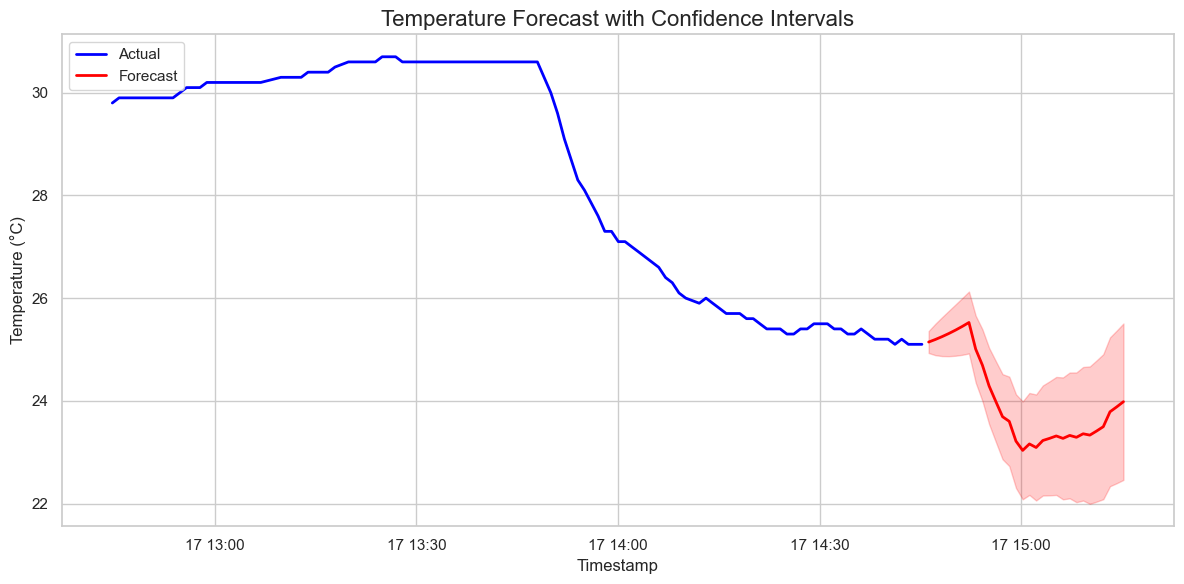

In [60]:
# Make sure forecast_periods match the number of forecast values
forecast_periods = 30  # For example, forecasting the next 30 minutes

# Forecast the values
forecast_values, conf_int = model.predict(n_periods=forecast_periods, return_conf_int=True)

# Create a forecast index for the next 'forecast_periods' minutes
forecast_index = pd.date_range(df.index[-1], periods=forecast_periods + 1, freq='T')[1:]

# Plot forecast with Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Plot the actual temperature values
sns.lineplot(x=df.index, y=df['Temperature (°C)'], label="Actual", color='blue', lw=2)

# Plot the forecasted temperature values
sns.lineplot(x=forecast_index, y=forecast_values, label="Forecast", color='red', lw=2)

# Add confidence interval
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2)

# Add labels and title
plt.title("Temperature Forecast with Confidence Intervals", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend(loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()
